In [3]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np

# Load the dataset from the datafile provided
df = pd.read_csv('/content/drive/MyDrive/jyoti/PupilBioTest_PMP_revA.csv')
print(f"DataFrame size: {df.size}")

# Shuffling Dataset to diversify the Tissue part
df_shuffled = df.sample(frac=1)

#Reducing the size of the Dataframe to 1 million consume less memory.
df = df_shuffled.head(1000000)

#clearing the useless dataframe
df_shuffled = None
print(f"New Data Size: {df.size}")


DataFrame size: 200098379
New Data Size: 13000000


In [5]:
#Question 1.1.1
# Ensure data is clean and organized by removing any missing values
df.dropna(inplace=True)

# Group the data by Tissue to calculate statistics for each tissue type separately
grouped = df.groupby('Tissue')

# Function to calculate the Coefficient of Variation (CV)
def calculate_cv(series):
    mean = series.mean()
    std_dev = series.std()
    cv = (std_dev / mean) * 100 if mean != 0 else 0
    return cv

# Dictionary to store results for each tissue type
results = {}

# Loop through each tissue type and calculate median and CV for each CpG site
for tissue, group in grouped:
    stats = {}
    for col in group.columns[2:10]:  # Coverage columns `000` to `111`
        median = group[col].median()  # Calculate the median
        cv = calculate_cv(group[col])  # Calculate the CV
        stats[col] = {'median': median, 'cv': cv}
    results[tissue] = stats

# Display the results
for tissue, stats in results.items():
    print(f"Tissue: {tissue}")
    for cpg_site, metrics in stats.items():
        print(f"  CpG Site: {cpg_site}, Median: {metrics['median']}, CV: {metrics['cv']:.2f} %")


Tissue: Islet
  CpG Site: `000, Median: 62.0, CV: 119.72%
  CpG Site: `001, Median: 0.0, CV: 290.77%
  CpG Site: `010, Median: 0.0, CV: 270.79%
  CpG Site: `011, Median: 0.0, CV: 391.62%
  CpG Site: `100, Median: 0.0, CV: 274.56%
  CpG Site: `101, Median: 0.0, CV: 421.08%
  CpG Site: `110, Median: 0.0, CV: 400.01%
  CpG Site: `111, Median: 0.0, CV: 346.63%
Tissue: cfDNA
  CpG Site: `000, Median: 405.0, CV: 137.03%
  CpG Site: `001, Median: 0.0, CV: 312.65%
  CpG Site: `010, Median: 0.0, CV: 301.40%
  CpG Site: `011, Median: 0.0, CV: 605.23%
  CpG Site: `100, Median: 0.0, CV: 290.19%
  CpG Site: `101, Median: 0.0, CV: 686.40%
  CpG Site: `110, Median: 0.0, CV: 611.41%
  CpG Site: `111, Median: 0.0, CV: 575.27%


In [6]:
%matplotlib inline

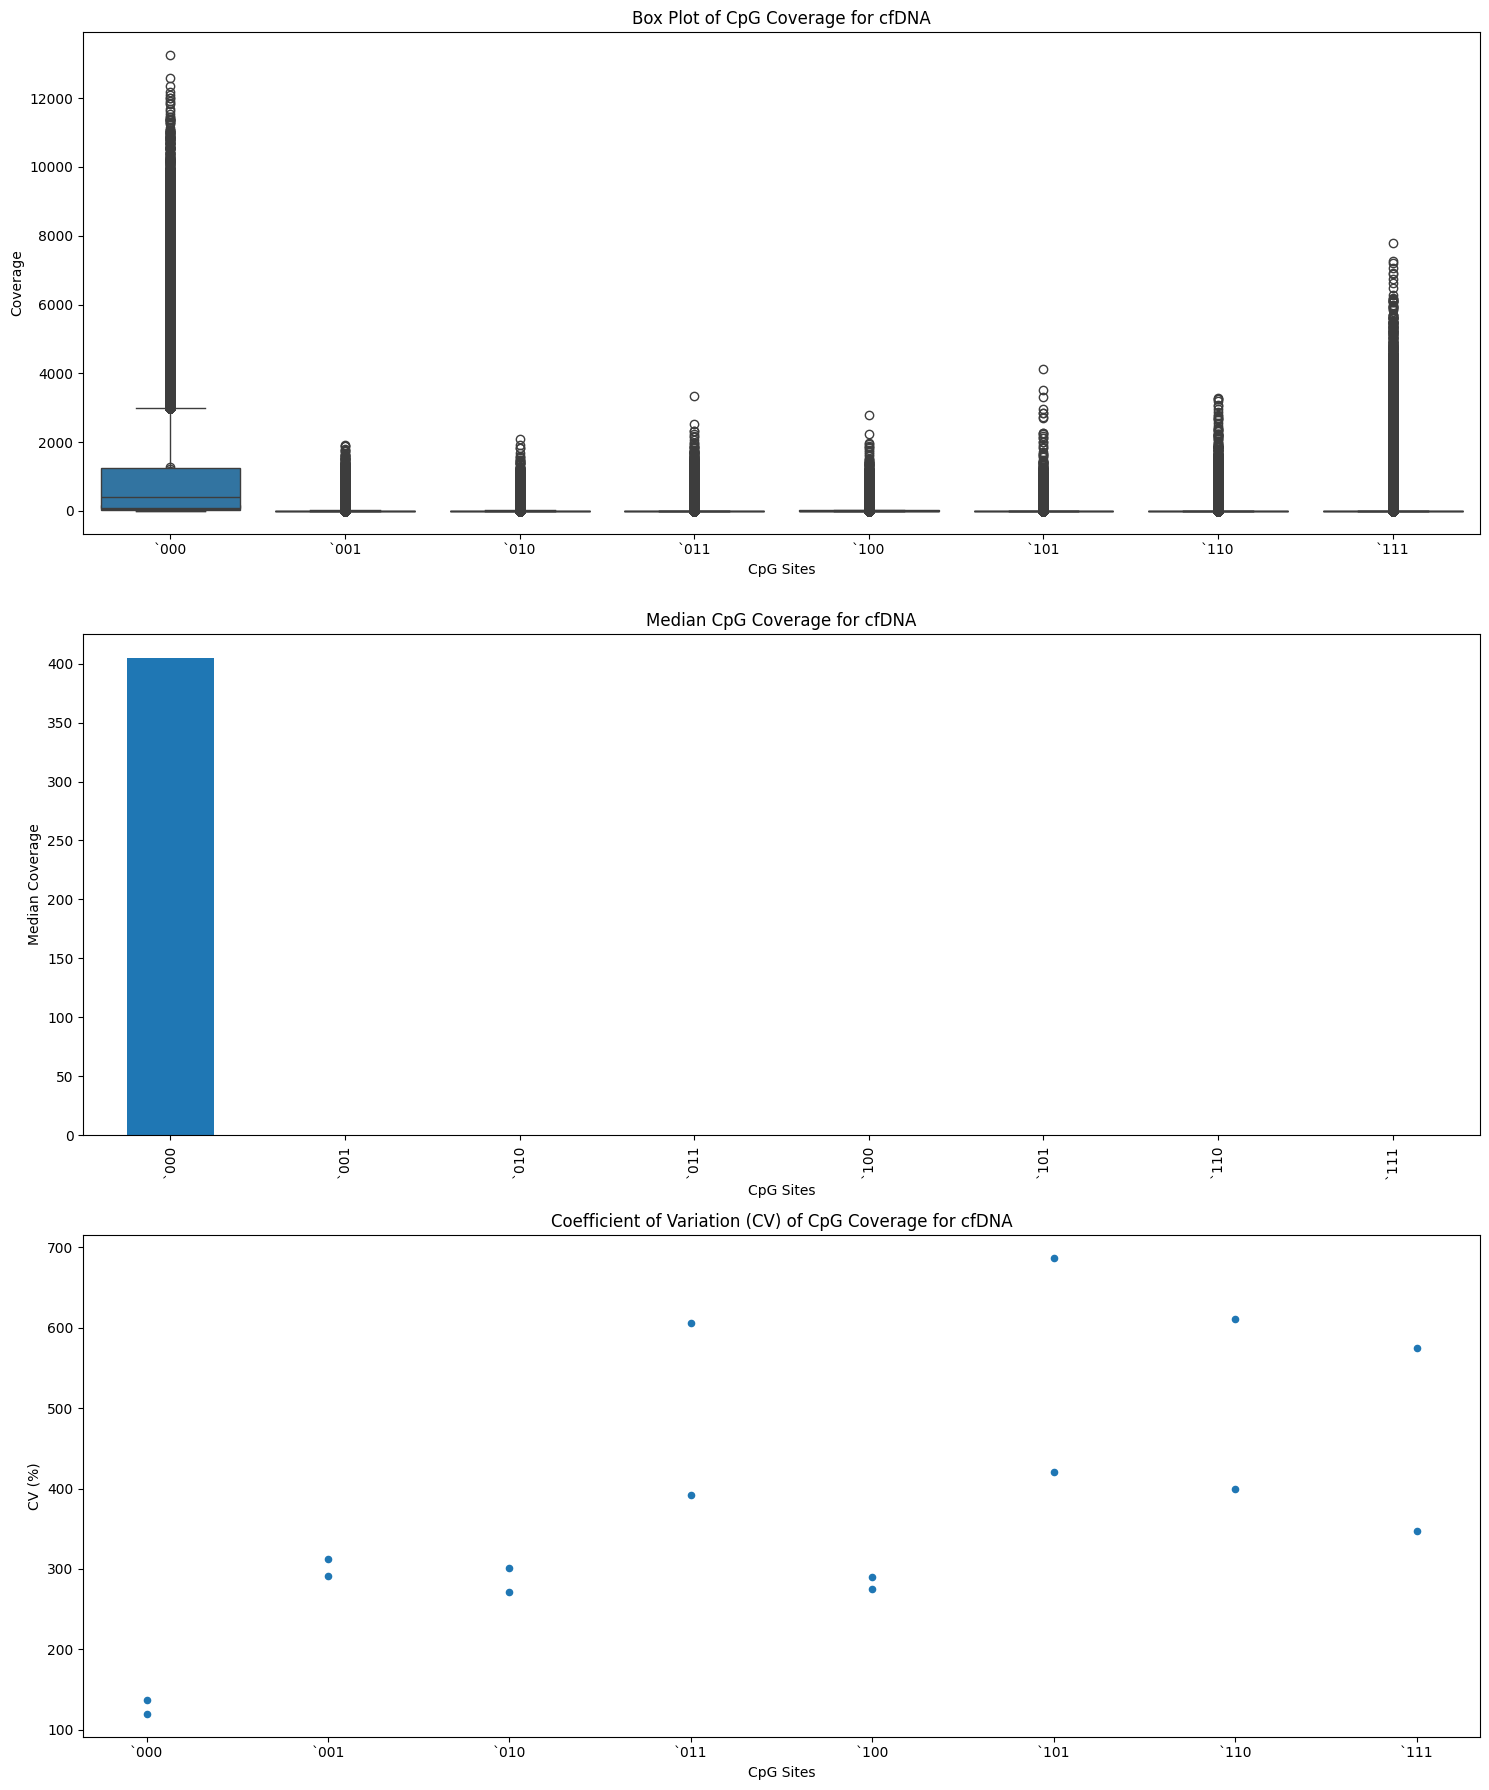

In [7]:
#Question 1.1.2
import matplotlib.pyplot as plt
import seaborn as sns

grouped = df.groupby('Tissue')
# Function to calculate CV (reused from above)
def calculate_cv(series):
    mean = series.mean()
    std_dev = series.std()
    cv = (std_dev / mean) * 100 if mean != 0 else 0
    return cv

# Initialize a figure for plots
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Plot for each tissue type
for i, (tissue, group) in enumerate(grouped):
    # Box plot for distribution of coverage
    sns.boxplot(data=group.iloc[:, 2:10], ax=axes[0])
    axes[0].set_title(f'Box Plot of CpG Coverage for {tissue}')
    axes[0].set_xlabel('CpG Sites')
    axes[0].set_ylabel('Coverage')

    # Calculate median and CV for each CpG site
    medians = group.iloc[:, 2:10].median()
    cvs = group.iloc[:, 2:10].apply(calculate_cv)

    # Bar plot for median coverage
    medians.plot(kind='bar', ax=axes[1])
    axes[1].set_title(f'Median CpG Coverage for {tissue}')
    axes[1].set_xlabel('CpG Sites')
    axes[1].set_ylabel('Median Coverage')

    # Convert CVs Series to DataFrame for scatter plot
    cvs_df = cvs.reset_index()
    cvs_df.columns = ['CpG Site', 'CV']

    # Scatter plot for CV
    cvs_df.plot(kind='scatter', x='CpG Site', y='CV', ax=axes[2])
    axes[2].set_title(f'Coefficient of Variation (CV) of CpG Coverage for {tissue}')
    axes[2].set_xlabel('CpG Sites')
    axes[2].set_ylabel('CV (%)')

# Adjust the layout
plt.tight_layout()
plt.show()


In [8]:
# Question 1.2.1
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Function to calculate p-values for each PMP using t-test
def calculate_p_values(df, tissue1_label):
    p_values = {}
    tissue1 = df[df['Tissue'] == tissue1_label]
    other_tissues = df[df['Tissue'] != tissue1_label]
    for col in df.columns[2:10]:  # PMP coverage columns
        _, p_value = ttest_ind(tissue1[col], other_tissues[col], equal_var=False)
        p_values[col] = p_value
    return p_values

# Calculate p-values for Tissue #1 (assuming Tissue #1 is labeled as 0)
p_values = calculate_p_values(df, tissue1_label=0)

# Filter PMPs with significant p-values (e.g., p < 0.05)
significant_pmps = {pmp: p for pmp, p in p_values.items() if p < 0.05}
print("Significant PMPs with p-values:", significant_pmps)

# Prepare the data for machine learning
X = df.iloc[:, 2:10]  # PMP coverage columns
y = df['Tissue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Identify important features (PMPs) based on feature importances
fi = model.feature_importances_
important_pmps = [X.columns[i] for i in range(len(fi)) if fi[i] > 0.05]
print("Important PMPs:", important_pmps)


Significant PMPs with p-values: {}
Classification Report:
               precision    recall  f1-score   support

       Islet       0.69      0.40      0.51     74219
       cfDNA       0.83      0.94      0.88    225781

    accuracy                           0.81    300000
   macro avg       0.76      0.67      0.69    300000
weighted avg       0.79      0.81      0.79    300000

Confusion Matrix:
 [[ 29802  44417]
 [ 13448 212333]]
Important PMPs: ['`000', '`001', '`010', '`100', '`111']


In [11]:
print(df.head)

<bound method NDFrame.head of          strand    CpG_Coordinates  `000  `001  `010  `011  `100  `101  `110  \
2300065       r     8736:8740:8807  2774     1     2     0     0     0     0   
12296074      f  13360:13368:13409  2924     1     0     0    15     0     0   
6021080       r     7235:7301:7364    47     0    12     0     0     0     0   
8746229       f     8565:8573:8682   826     7     1     0     0     0     0   
12144718      f     8500:8553:8598   608     0    18     0     0     0     0   
...         ...                ...   ...   ...   ...   ...   ...   ...   ...   
15135198      f     8464:8479:8517    42     0     0     0     0     0     0   
6738561       r  13415:13498:13505    72     4     0     1     1     8     0   
14322977      f     8333:8388:8420    23     2     0     0     0     0     0   
9347203       f     8591:8632:8692   442     0     0     0     0     0     0   
8408148       f     9873:9877:9957  1027     0     0     0     0     0     0   

         

In [18]:
#Question 1.2.2

# Specify the range of columns that represent the PMPs
pmp_columns = df.columns[2:10]

# Calculate variant read fractions (VRF) for each PMP
for pmp in pmp_columns:
    df[f'vrf_{pmp}'] = df[pmp] / df[pmp_columns].sum(axis=1)

# Calculate mean VRF for each PMP in both tissues
mean_vrf_per_pmp_tissue = df.groupby('Tissue')[[f'vrf_{pmp}' for pmp in pmp_columns]].mean().reset_index()

print(mean_vrf_per_pmp_tissue)




  Tissue  vrf_`000  vrf_`001  vrf_`010  vrf_`011  vrf_`100  vrf_`101  \
0  Islet  0.844559  0.024278  0.020356  0.014883  0.021653  0.012468   
1  cfDNA  0.907256  0.015745  0.013760  0.007599  0.016339  0.004126   

   vrf_`110  vrf_`111  
0  0.014122  0.047681  
1  0.007447  0.027728  


Question 1.3.

a. How does sequencing depth affect specificity confidence?

Sequencing depth affects the confidence in detecting true methylation patterns by reducing noise and increasing the accuracy of measurements. Higher sequencing depth allows for better discrimination between true signals and sequencing errors, thus improving specificity.

In practical terms, higher sequencing depth ensures that even low-abundance methylation patterns are detected with greater reliability, minimizing false positives and increasing the specificity of biomarkers.

b. For the top 10 PMPs, estimate the threshold of reads required to confidently call Tissue #2 at a sequencing depth of 1 million reads

We can estimate the threshold of reads required to confidently call Tissue #2 by analyzing the distribution of read counts and calculating the minimum number of reads needed for reliable detection. This involves looking at the read coverage for the top 10 PMPs and determining the cutoff where the detection is robust.

In [21]:
#Question 1.3.3
# Function to evaluate specificity
def evaluate_specificity(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=True)

# Evaluate specificity for the top 10 PMPs
X_top_pmps = X[top_10_pmps]
X_train_top_pmps, X_test_top_pmps, y_train_top_pmps, y_test_top_pmps = train_test_split(X_top_pmps, y, test_size=0.3, random_state=42)
model_top_pmps = RandomForestClassifier(random_state=42)
model_top_pmps.fit(X_train_top_pmps, y_train_top_pmps)
specificity_top_pmps = evaluate_specificity(model_top_pmps, X_test_top_pmps, y_test_top_pmps)

# Evaluate specificity for individual CpG sites
specificity_individual = {}
for col in X.columns:
    X_individual = X[[col]]
    X_train_individual, X_test_individual, y_train_individual, y_test_individual = train_test_split(X_individual, y, test_size=0.3, random_state=42)
    model_individual = RandomForestClassifier(random_state=42)
    model_individual.fit(X_train_individual, y_train_individual)
    specificity_individual[col] = evaluate_specificity(model_individual, X_test_individual, y_test_individual)

# Print the results
print("Specificity for top 10 PMPs:\n", specificity_top_pmps)
print("Specificity for individual CpG sites:\n", specificity_individual)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Specificity for top 10 PMPs:
 {'Islet': {'precision': 0.6423615222487982, 'recall': 0.365472453145421, 'f1-score': 0.46588118097659, 'support': 74219.0}, 'cfDNA': {'precision': 0.8173043724517308, 'recall': 0.9331121750723046, 'f1-score': 0.8713773435852046, 'support': 225781.0}, 'accuracy': 0.79268, 'macro avg': {'precision': 0.7298329473502645, 'recall': 0.6492923141088628, 'f1-score': 0.6686292622808973, 'support': 300000.0}, 'weighted avg': {'precision': 0.7740240944543593, 'recall': 0.79268, 'f1-score': 0.7710589446097087, 'support': 300000.0}}
Specificity for individual CpG sites:
 {'`000': {'Islet': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 74219.0}, 'cfDNA': {'precision': 0.7526033333333333, 'recall': 1.0, 'f1-score': 0.8588404677993309, 'support': 225781.0}, 'accuracy': 0.7526033333333333, 'macro avg': {'precision': 0.37630166666666665, 'recall': 0.5, 'f1-score': 0.42942023389966544, 'support': 300000.0}, 'weighted avg': {'precision': 0.5664117773444444, 'r

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
